In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
!pip install matplotlib-label-lines
!pip install seaborn

## Key Function: `extract(...)`
Given a log like this:

```log
...
| train | epoch 7 batch 28 | training accuracy 0.871665386765902
| train | epoch 7 batch 29 | training accuracy 0.8788481756788991
| valid | epoch 7 | valid on 'valid' subset | accuracy 0.8693746861152197 loss 0.12917969546808372 | cost 10 seconds
| train | epoch 8 batch 0 | training accuracy 0.8943217573123977
| train | epoch 8 batch 1 | training accuracy 0.8954696157331422
...
```

If we want to extract the `validation accuracy` and `validation loss` from the log, 
we have to specify two factors:

- **filters** : a function (returning True/False) which can help filter useless lines
    - `FILTERS["include"]("valid")`: a line must contain `valid`
    - `FILTERS["exclude"]("test")`: a line must not contain `test`
    - `your customized filters...`

- **patterns**: a regex pattern which extract the number
    - `"epoch (\d+)"`: a pattern such as `epoch 3`, `epoch 4`, etc.
    - `f"loss {PATTERNS['FLOAT']}"`: a pattern (`PATTERNS['FLOAT']` is a predefined pattern) such as `loss 1.23`, `loss 0.3333`, etc.
    - `your customized patterns...`

- **reduce_fns**: a function which defines how to reduce the resules
    - no reduction by default
    - `max`
    - `min`
    - `last`


In [1]:
from manytasks.config_loader import load_config
from manytasks.shared import TaskPool

load_config("task.logs/config.json")
taskpool = TaskPool()

from manytasks.extraction import extract, FILTERS, PATTERNS, REDUCE_FNS

## Plotting the Training Curve of Each Log


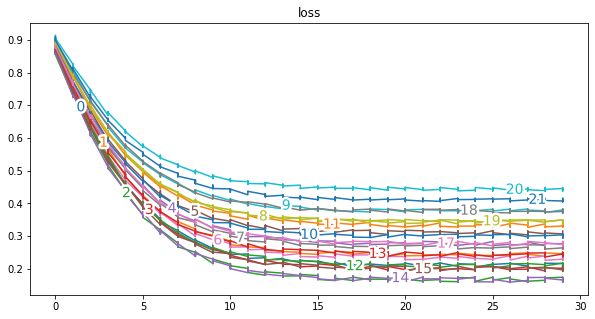

In [3]:
import os
import matplotlib.pyplot as plt
from labellines import labelLines

plt.figure(figsize=(10, 5))

for idx, task in enumerate(taskpool):
    if not os.path.exists(f"task.logs/task-{idx}.txt"):
        continue
    ret = extract(
        lines=open(f"task.logs/task-{idx}.txt"), 
        filters=[
            FILTERS["include"]("epoch")
        ], 
        patterns={
            "epoch": f"epoch {PATTERNS['INT']}",
            "loss": f"loss {PATTERNS['FLOAT']}"
        }
    )
    if len(ret["epoch"]) > 1:
        plt.plot(ret["epoch"], ret["loss"], label=f'{idx}')

plt.title("loss")
labelLines(plt.gca().get_lines(), align=False, fontsize=14)

pass

## Performing Factor Analysis on Validation Results

In [4]:
import os
import pandas as pd

data = []
for idx, task in enumerate(taskpool):
    if not os.path.exists(f"task.logs/task-{idx}.txt"):
        continue
    datum = {key: task[key] for key in task.keys}
    ret = extract(
        lines=open(f"task.logs/task-{idx}.txt"), 
        filters=[
            FILTERS["include"]("epoch")
        ], 
        patterns={
            "bleu": f"bleu {PATTERNS['FLOAT']}"
        },
        reduce_fns={
            "bleu": REDUCE_FNS['max']
        }
    )
    datum["bleu"] = ret['bleu']
    data.append(datum)

data = pd.DataFrame(data)
data

,__1,--arch,--layer,--opt,--lr,--decay,bleu
0,wmt14,lstm,2,adam,1e-2,0.01,23.860891
1,wmt14,lstm,2,adam,1e-2,0.001,22.752388
2,wmt14,lstm,2,adam,5e-4,0.01,25.175892
3,wmt14,lstm,2,adam,5e-4,0.001,24.224497
4,wmt14,lstm,5,adam,1e-2,0.01,21.838128
5,wmt14,lstm,5,adam,1e-2,0.001,20.883781
6,wmt14,lstm,5,adam,5e-4,0.01,23.222965
7,wmt14,lstm,5,adam,5e-4,0.001,22.194777
8,wmt14,transformer,2,adam,1e-2,0.01,19.856010
9,wmt14,transformer,2,adam,1e-2,0.001,18.828265


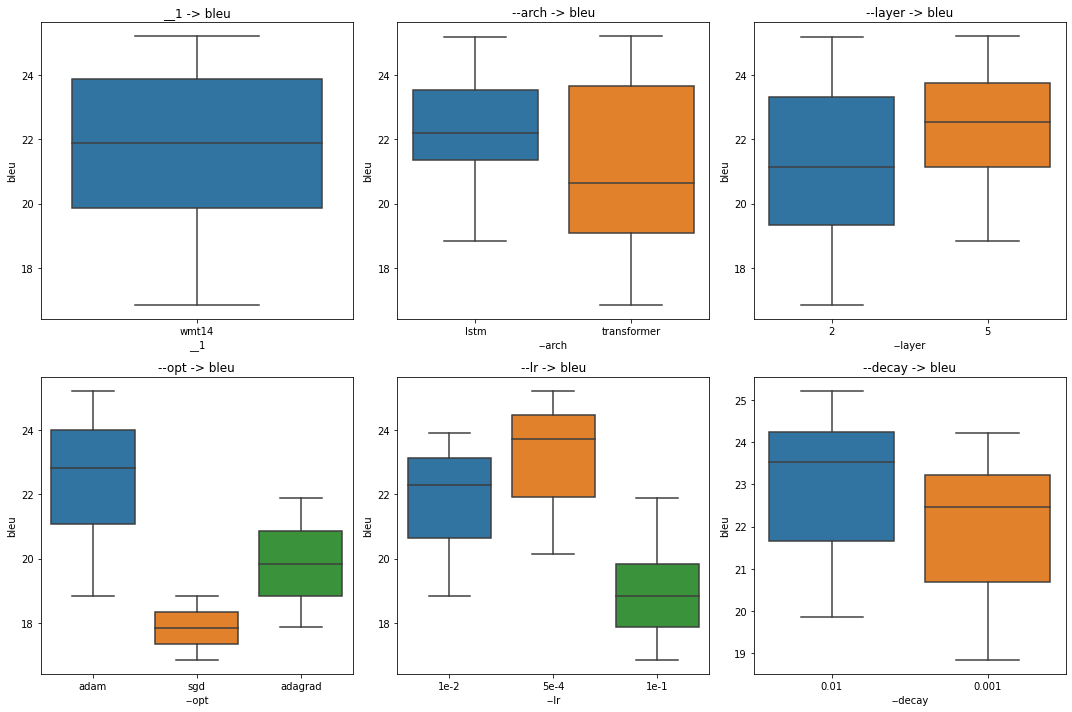

In [5]:
from matplotlib import pyplot as plt
import seaborn  as sns

num_y = 1
num_x = len(data.keys()) - num_y
total_num = num_x * num_y

row = 2
col = total_num // row + total_num % row

subfig_idx = 0
fig, axes = plt.subplots(row, col, figsize=(col * 5, row * 5))

for key in data.keys()[:num_x]:
    for val in data.keys()[num_x:]:
        subfig_idx += 1
        plt.subplot(row, col, subfig_idx)
        plt.title(f"{key} -> {val}")
        sns.boxplot(x=key, y=val, data=data)
fig.tight_layout()